<span style="font-size: 14pt">MIPT, Advanced ML, Autumn 2017</span>

<span style="font-size: 16pt"> HW #3: ARIMAX, Compositions

<span style="color:blue; font-size: 12pt">Alexey Romanenko </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

**Дополнительный материал для выполнения дз**:
- Магнус Я.Р., Катышев П.К., Пересецкий А.А. Эконометрика. Начальный курс., глава 11
- Лукашин Ю.П. Адаптивные методы краткосрочного прогнозирования временных рядов. Финансы и статистика. 2003, главы 1,4,5,7.

**Оформление дз**: 
- Присылайте выполненное задание на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2017_Aut_fall <номер_группы> <фамилия>``, к примеру -- ``ML2017_Aut_fall 401 ivanov``
- Выполненное дз сохраните в файл ``<фамилия>_<группа>_task<номер>.ipnb``, к примеру -- ``ivanov_401_task1.ipnb``

**Вопросы**:
- Присылайте вопросы на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2017_Aut_fall Question <Содержание вопроса>``

<span style="color:red; font-size: 14pt;"> DEADLINE: 10 October 2017 23:59:59 </span>

--------
- **PS1**: Мы используем автоматические фильтры, и просто не найдем ваше дз, если вы не аккуратно его подпишите.
- **PS2**: Напоминаем, что дедлайны жесткие, письма пришедшие после автоматически удаляются =( чтобы соблазна не было 


<h1 align="center">Check Questions (20%)</h1> 

Ответе на вопросы своими словами (загугленный материал надо пересказать), ответ обоснуйте (напишите и ОБЪЯСНИТЕ формулки если потребуется), если не выходит, то вернитесь к лекции дополнительным материалам:

**Вопрос 1** Опишите ситуацию (аргументированно), в котором композиция Adaptive Selection будет прогнозировать хуже, чем лучший из базовых алгоритмов.

Пусть $Y[t] = const$ - константный временной ряд. Пусть каждый из базовых алгоритмов дает предсказания $Y_n[t] = const + \delta(\varepsilon), n \in [1,2,\dots]$. Наилучший будет для $n = 1$. Но можно так выбрать $\delta(\varepsilon)$ что для композиции будут выбраны несколько базовых алгоритмов, помимо лучшего. Тогда $Y_{\text{mix}} < 1 - \delta = Y_1[t] < 1$. Композиция работает хуже.

**Вопрос 2**  Опишите ситуацию (аргументированно), в котором композиция Adaptive Composition будет прогнозировать хуже, чем лучший из базовых алгоритмов.

Возьмем опять константный ряд. Веса для adaptive composition выберутся в зависимости от качества алгоритма, но предсказанные значения все равно будут меньше чем для алгоритма с $n = 1$.

**Вопрос 3** Что значит смешиваемость (mixability) игры (в теории агрегирующего алгоритма)?

можно ли смешать игры чтобы результат был лучше чем в каждой отдельной

**Вопрос 4**: Верно ли, что для смешиваемых игр процесс потерь любой композиции (любого алгоритма) будет расти со временем (с ростом $t$) не быстрее, чем процесс потерь лучшего из базовых алгоритмов? Если нет - приведит пример, когда это не так.

### $$ \mathrm{Loss}_{Composition}(T)\leq \inf\limits_{BA} \mathrm{Loss}_{BA}(T)+C$$

Композиция может быть очень плохой, например которая берет предсказания худшего алгоритма. 
Пусть есть детерминированный процесс, у лучшего алгоритма будет точность 100%, т.е. $\text{CumLoss} = C_0$, тогда как точность плохого алгоритма будет расти. 

<h1 align="center">2. Contest: electricity comsumption contest (80%)</h1>
Take part in <a href='https://www.kaggle.com/t/de102b28cae74e6ead7492ff12efbc63'>contest</a>.
<span style='color:red'> You need to send the final code that is used for building forecast.</span>

In [3]:
import numpy as np
from datetime import datetime, timedelta
import pylab
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import math
import pandas.tseries.offsets as ofs
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa import stattools

import warnings as w
from IPython.display import Image

from utils import qualityMACAPE, qualityRMSE, InitExponentialSmoothing, AdaptiveExponentialSmoothing

%matplotlib inline

In [10]:
train = pd.read_csv('train.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Date')
print(train.shape)
test = train[train['ACTUAL'].isnull()]
train.dropna(inplace=True)
print(train.shape, test.shape)
test.drop(['ACTUAL'], axis=1, inplace=True)
train.head()

(21207, 6)
(20546, 6) (660, 6)


C:\Users\Andrey\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ID,tsID,ACTUAL,Temp,Saturday,Sunday
Date,,,,,,
2010-01-01,1,4,35489.95,-0.9,0.0,1
2010-01-02,2,4,35413.59,-0.1,1.0,0
2010-01-03,3,4,34802.67,-3.9,0.0,1
2010-01-04,4,4,36003.84,-13.7,0.0,1
2010-01-05,5,4,37622.96,-16.9,0.0,1


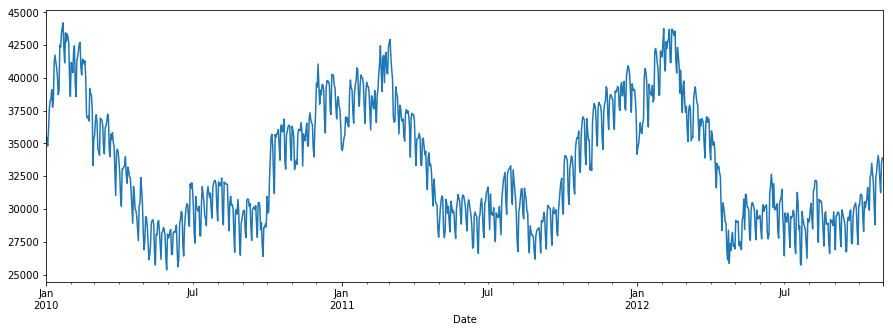

In [14]:
ts4 = train[train['tsID'] == 4]
ts4['ACTUAL'].plot(figsize=(15, 5))

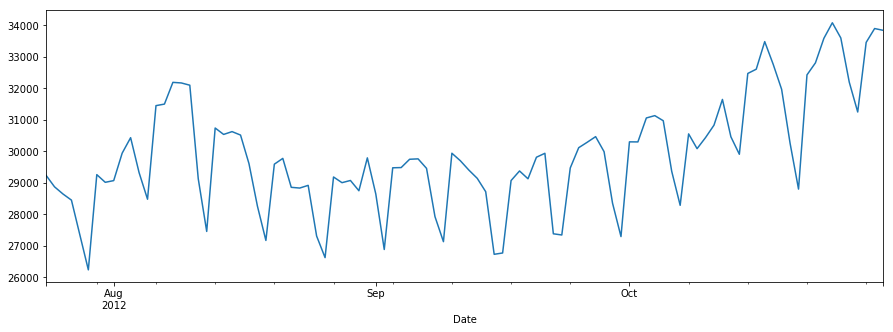

In [16]:
ts4['ACTUAL'].tail(100).plot(figsize=(15,5))

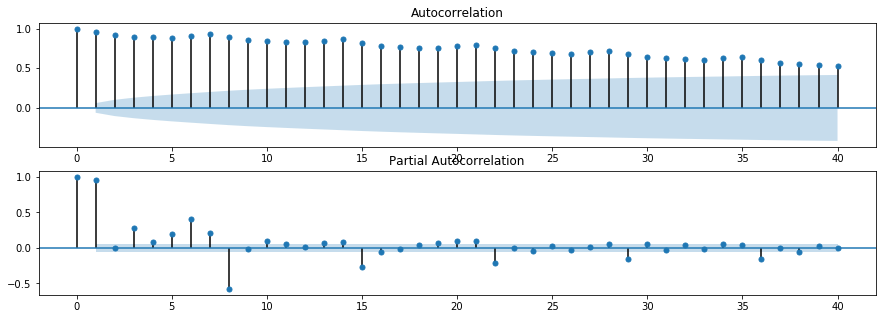

In [17]:
# acf
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts4['ACTUAL'].values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts4['ACTUAL'].values.squeeze(), lags=40, ax=ax2)

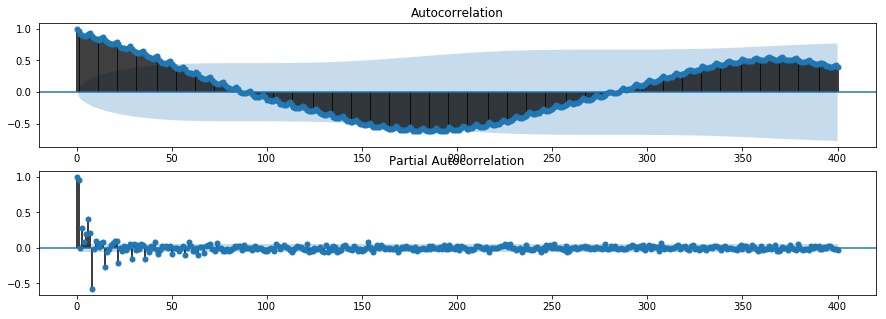

In [18]:
# acf
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts4['ACTUAL'].values.squeeze(), lags=400, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts4['ACTUAL'].values.squeeze(), lags=400, ax=ax2)

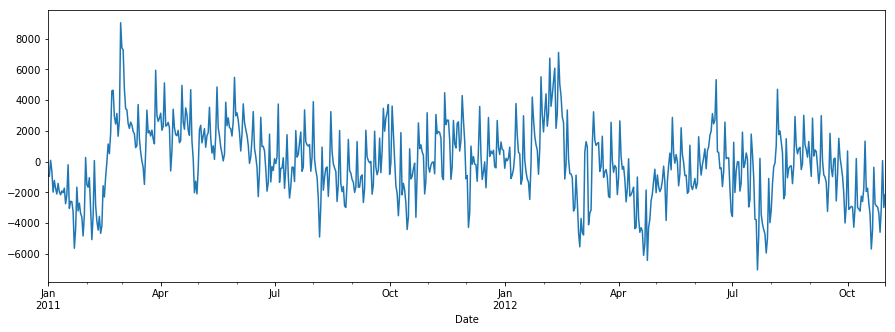

In [20]:
# Differencing
p = 365
ts4_shift365 = (ts4 - ts4.shift(p))[p:]
ts4_shift365['ACTUAL'].plot(figsize=(15,5))

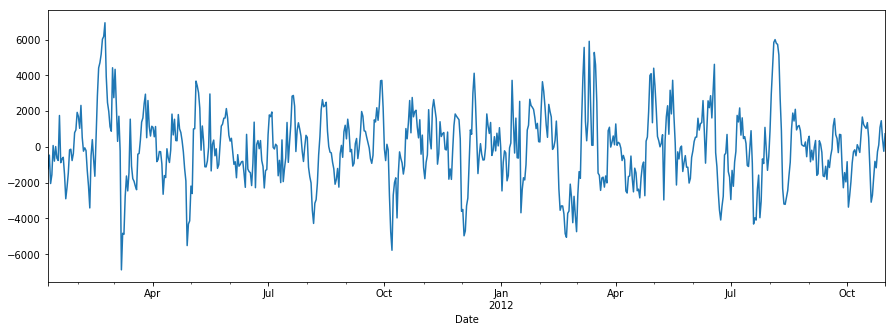

In [22]:
p=7
ts4_dif7_shift365 = (ts4_shift365 - ts4_shift365.shift(p))[p:]
ts4_dif7_shift365['ACTUAL'].plot(figsize=(15,5))

In [23]:
# Stationary test
kpss_stat= stattools.kpss(np.array(ts4_dif7_shift365['ACTUAL']))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.037635, 
pvalue: 0.10 
maximal Lag: 20 
table distribution: {'5%': 0.463, '2.5%': 0.574, '1%': 0.739, '10%': 0.347}


C:\Users\Andrey\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [ ]:
# Put your code for 
final_forecast = ???

In [80]:
# save forecast to disk for further submission
final_forecast.save('result.csv', format='csv')